In [1]:
import joblib
import math
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from nilearn.connectome.connectivity_matrices import sym_matrix_to_vec
from neuroginius.plotting import plot_matrix

from cogpred.utils.configuration import get_config

config = get_config()
conn_dir = config["connectivity_matrices"]

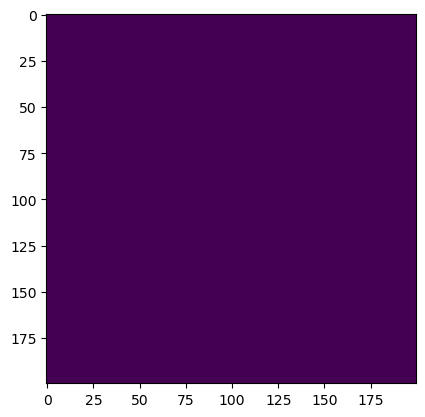

In [166]:
from neuroginius.synthetic_data.generation import generate_topology, generate_topology_net_interaction
from neuroginius.atlas import Atlas


refnet = "Default"
atlas = Atlas.from_name("schaefer200")

topology = generate_topology(refnet, atlas.macro_labels)
#networks = np.unique(atlas.macro_labels)
#
#for network in networks:
#    new = generate_topology_net_interaction((refnet, network), atlas.macro_labels)
#    topology += new

topology = np.where(topology != 0, 1, 0)
topology = np.ones((200, 200))
plt.imshow(topology)
plt.show()

In [170]:
ATLAS = "schaefer200"
k = 3

import os
from cogpred.loading import make_training_data
from cogpred.utils.naming import make_run_path

matrices, metadata = make_training_data(conn_dir, ATLAS, k)
run_path = make_run_path(config["output_dir"], k=k, feat="fc", atlas=ATLAS, groupkfold=True, net="allbrain")
os.makedirs(run_path, exist_ok=True)
metadata.to_csv(run_path / "metadata.csv")

Dropping 8 subjects because of lacking MMMSE


In [171]:
# Set non default to 0, transform to vec, and extract non zero coefficients
matrices *= topology

X = []
for mat in matrices:
    vec = sym_matrix_to_vec(mat, discard_diagonal=True)
    vec_idx = np.flatnonzero(vec) # Should only be computed once
    X.append(vec[vec_idx])

X = np.stack(X)
y = metadata.cluster_label
assert len(X) == len(y)

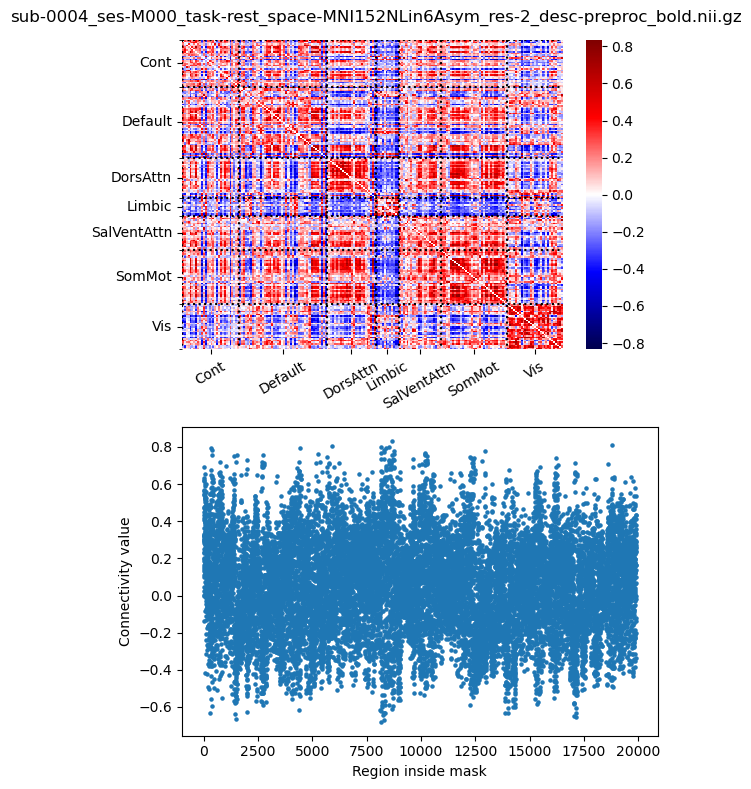

In [172]:
i = 2
row = metadata.iloc[i]
fig, ax = plt.subplots(2, 1, figsize=(6, 8))

plot_matrix(matrices[i], atlas, axes=ax[0])

ax[1].scatter(np.arange(X.shape[1]), X[i], s=5)
ax[1].set_xlabel("Region inside mask")
ax[1].set_ylabel("Connectivity value")

fig.suptitle(f"{row.file_basename}")
fig.tight_layout()
plt.show()

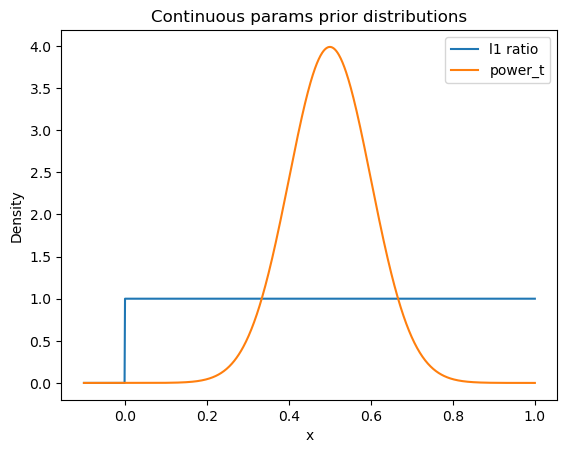

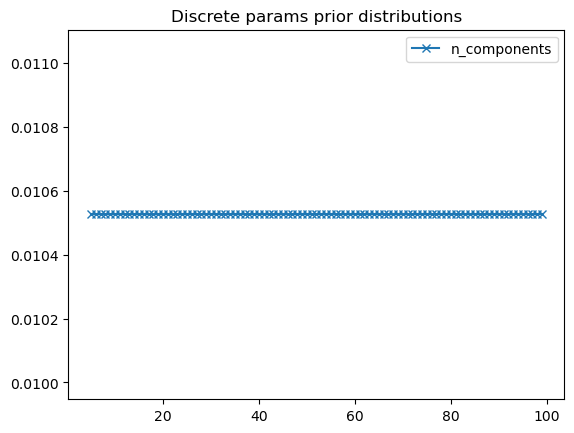

In [173]:
from scipy import stats

#lambda_param = 1 / 1e-4
lambda_param = 1000
alpha_distribution = stats.expon(scale=1/lambda_param)
l1_ratio = stats.uniform(0, 1)
#l1_ratio = stats.beta(1.5, 3) # TODO Try higher l1_ratio with high n_comps
#l1_ratio = stats.expon(scale=1/7)
power_t = stats.norm(loc=0.5, scale=0.1)

x = np.linspace(-0.1, 1, 1000)
da = alpha_distribution.pdf(x)
dl = l1_ratio.pdf(x)
dt = power_t.pdf(x)


#plt.plot(x, da, label="alpha")
plt.plot(x, dl, label="l1 ratio")
plt.plot(x, dt, label="power_t")
plt.title("Continuous params prior distributions")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.show()

n_features = X.shape[1]
n_comps = list(range(5, 100))
dc = np.ones((len(n_comps))) * 1 / len(n_comps)
plt.plot(n_comps, dc, label="n_components", marker="x")
plt.title("Discrete params prior distributions")

plt.legend()
plt.show()

In [174]:
param_dist = {
    "classifier__loss": ["hinge", "log_loss", "modified_huber"],
    "classifier__alpha": alpha_distribution,
    "classifier__l1_ratio": l1_ratio,
    "classifier__power_t": power_t,
    #"reduction__n_components": n_comps
}

In [175]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupShuffleSplit, train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn import preprocessing
from sklearn.model_selection import (
    cross_validate, cross_val_predict, KFold, RandomizedSearchCV, StratifiedKFold
)

from sklearn.decomposition import PCA
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.metrics import f1_score
from functools import partial

from sklearn.model_selection import cross_val_predict, KFold, RandomizedSearchCV, cross_val_score
from cogpred.supervised import macro_f1

sgd = SGDClassifier(
    penalty="elasticnet",
    class_weight="balanced", 
    random_state=1999
)

clf = Pipeline(
    [
    ("scaler", preprocessing.StandardScaler()),
    #("reduction", PCA()),
    ("classifier", sgd)
    ],
    verbose=False
)

#inner_cv = GroupShuffleSplit(n_splits=8, random_state=1999).split(X, y, groups=metadata.CEN_ANOM.values)
inner_cv = StratifiedKFold(n_splits=8, shuffle=True, random_state=1999)
outer_cv = GroupShuffleSplit(n_splits=8, random_state=1999)


search = RandomizedSearchCV(
    clf,
    param_distributions=param_dist,
    n_iter=100,
    scoring=macro_f1,
    cv=inner_cv,
    random_state=1999,
    verbose=1,
    n_jobs=8,
    error_score="raise"
)

In [176]:
search.fit(X, y)
cv_results = pd.DataFrame(search.cv_results_).sort_values(by="mean_test_score", ascending=False)
cv_results

Fitting 8 folds for each of 100 candidates, totalling 800 fits


/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Co

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__alpha,param_classifier__l1_ratio,param_classifier__loss,param_classifier__power_t,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,mean_test_score,std_test_score,rank_test_score
17,14.519203,1.458723,0.026841,0.002493,0.000174,0.044448,modified_huber,0.411966,"{'classifier__alpha': 0.00017363343311961607, ...",0.410397,0.359677,0.436169,0.382587,0.306869,0.318357,0.415126,0.391775,0.377619,0.043264,1
60,13.775911,0.603080,0.026165,0.001233,0.001864,0.324291,modified_huber,0.445470,"{'classifier__alpha': 0.0018635570771715778, '...",0.349121,0.427044,0.412519,0.346281,0.345032,0.336476,0.376762,0.418847,0.376510,0.035179,2
23,12.797672,0.484680,0.024622,0.001504,0.000230,0.442006,log_loss,0.471093,"{'classifier__alpha': 0.00023019133662771087, ...",0.348238,0.442466,0.379822,0.350638,0.333925,0.290273,0.403303,0.460778,0.376180,0.053500,3
36,13.877879,0.931404,0.027150,0.003466,0.000409,0.291423,log_loss,0.522636,"{'classifier__alpha': 0.0004085770784429921, '...",0.338668,0.410021,0.407367,0.304569,0.342262,0.319643,0.413122,0.459714,0.374421,0.051621,4
41,15.242611,1.338864,0.026843,0.002074,0.000343,0.142226,log_loss,0.562910,"{'classifier__alpha': 0.0003431993466302723, '...",0.342119,0.478338,0.379511,0.390947,0.316031,0.316431,0.394752,0.373250,0.373922,0.049151,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45,30.742832,7.242667,0.030774,0.003736,0.000702,0.963131,hinge,0.383569,"{'classifier__alpha': 0.0007023507324455655, '...",0.309531,0.353312,0.344501,0.250958,0.314626,0.200955,0.319798,0.349805,0.305436,0.049973,96
68,70.258341,48.796241,0.027420,0.001905,0.000971,0.993877,log_loss,0.508933,"{'classifier__alpha': 0.0009713204162961679, '...",0.291936,0.350883,0.332674,0.247897,0.297132,0.238874,0.349129,0.333775,0.305287,0.041097,97
88,22.913515,3.535060,0.024832,0.002856,0.000679,0.927934,hinge,0.528538,"{'classifier__alpha': 0.000679150316087699, 'c...",0.304937,0.316111,0.315431,0.254500,0.304767,0.223558,0.349706,0.342836,0.301481,0.039916,98
33,236.524090,104.918201,0.028757,0.001775,0.002471,0.973746,log_loss,0.502613,"{'classifier__alpha': 0.00247068364224944, 'cl...",0.251875,0.358100,0.297453,0.297586,0.296786,0.257137,0.311224,0.334064,0.300528,0.033233,99


In [177]:
est = search.best_estimator_
reg = est.named_steps["classifier"]

In [110]:
def dmn_select(label):
    if label == "Default":
        return 1
    return 0

dmn_regions = []
for region, network in zip(atlas.labels, atlas.macro_labels):
    if network == "Default":
        dmn_regions.append(region)

# Hack to remove that annoying dtype thing from nilearn
dmn_regions = list(np.array(dmn_regions).astype(str))

n_regions = sum(map(dmn_select, atlas.macro_labels))

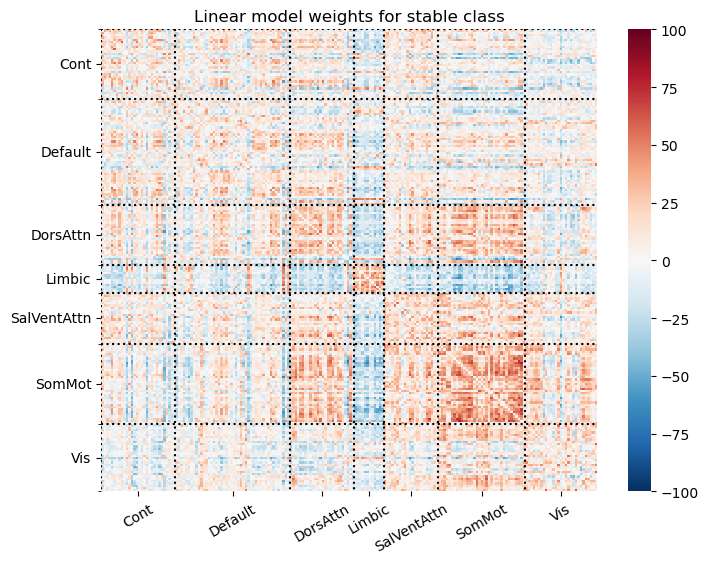

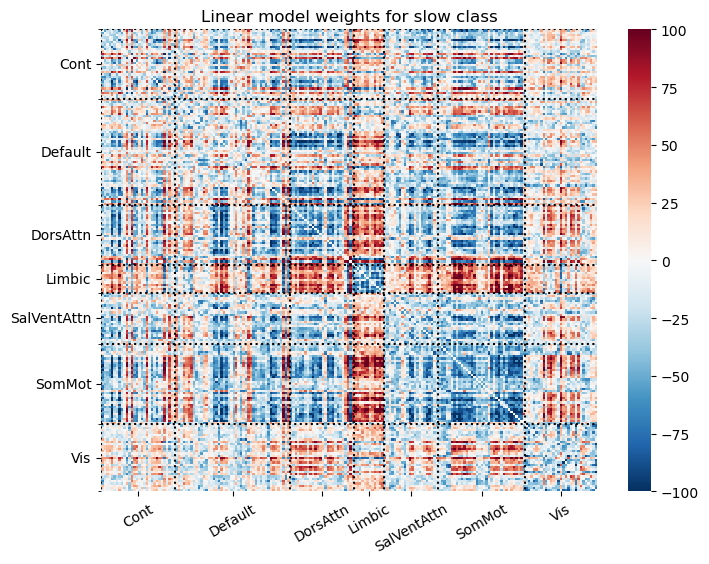

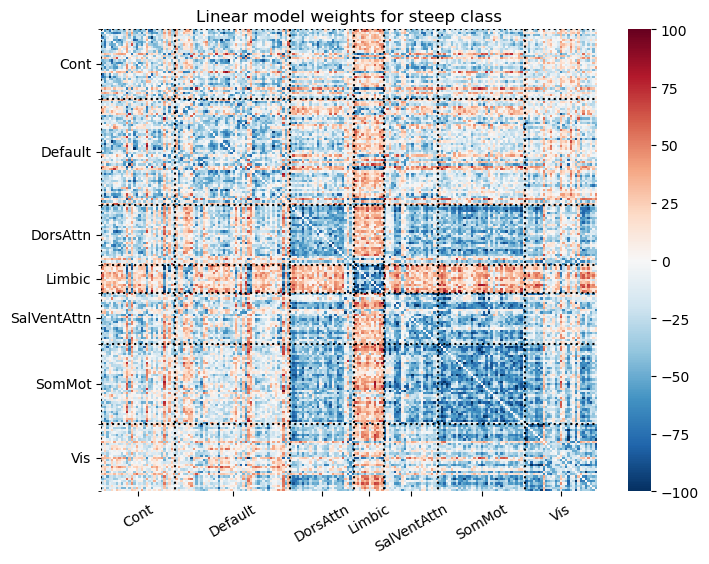

In [184]:
from nilearn.connectome import vec_to_sym_matrix
def region_split(label):
    return label.split("_")[-2]

class MockAtlas:
    macro_labels = list(map(region_split, dmn_regions))
    
cats = ("stable", "slow", "steep")
for i in range(k):
    coefs = reg.coef_[i, :]
    # Perform Hauf transform to interpret coeffecients
    arr = vec_to_sym_matrix(np.cov(X.T) @ coefs, diagonal=np.zeros(matrices.shape[1]))
    cat = cats[i]
    axes = plot_matrix(
        np.where(np.abs(arr) > 0, arr, 0),
        atlas,
        cmap="RdBu_r",
        bounds=(-100, 100)
    )
    axes.set_title(f"Linear model weights for {cat} class")
    plt.show()

Text(0.5, 0.92, 'Randomized grid search')

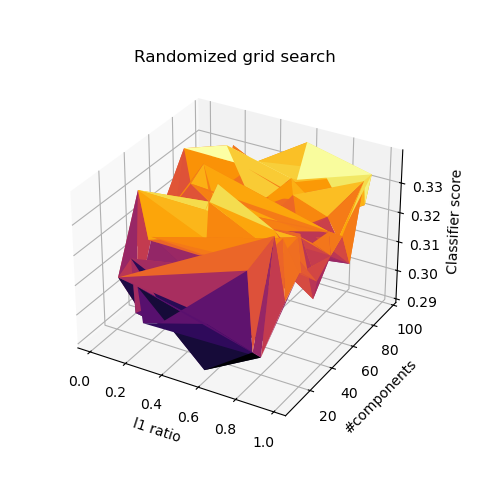

In [14]:
from matplotlib import cm

x = cv_results.param_classifier__l1_ratio.values
y = cv_results.param_reduction__n_components.values
z = cv_results.mean_test_score.values
yy, xx = np.meshgrid(y, x)


fig, ax = plt.subplots(subplot_kw={"projection":"3d"})
ax.plot_trisurf(x, y, z, cmap=cm.inferno, linewidth=0.2)
plt.xlabel("l1 ratio")
plt.ylabel("#components")
ax.set_zlabel("Classifier score")
ax.set_title("Randomized grid search")



In [189]:
test_scores = cross_val_score(
    search, X, y, cv=outer_cv.split(X, y, groups=metadata.CEN_ANOM.values), n_jobs=8, scoring=macro_f1, verbose=1
) # TODO Get hyperparameters
test_scores

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 8 folds for each of 100 candidates, totalling 800 fits
Fitting 8 folds for each of 100 candidates, totalling 800 fits
Fitting 8 folds for each of 100 candidates, totalling 800 fits
Fitting 8 folds for each of 100 candidates, totalling 800 fits
Fitting 8 folds for each of 100 candidates, totalling 800 fits
Fitting 8 folds for each of 100 candidates, totalling 800 fits
Fitting 8 folds for each of 100 candidates, totalling 800 fits
Fitting 8 folds for each of 100 candidates, totalling 800 fits


/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Co

In [ ]:
import joblib
joblib.dump(test_scores, run_path / "test_scores.joblib")
joblib.dump(search.best_estimator_, run_path / "best_estimator.joblib")
cv_results.to_csv(run_path / "cv_results.csv")